In [1]:
# standard python utilities
import os
import sys
import glob
import pandas as pd
import numpy as np
import calendar
import time

# unique functions for this notebook
import numpy.ma as ma
from scipy.stats import hmean
from scipy.stats import gmean

# standard python plotting utilities
import matplotlib as mpl
import matplotlib.pyplot as plt

# standard geospatial python utilities
import pyproj # for converting proj4string
import shapely
import geopandas as gpd
import rasterio

# mapping utilities
import contextily as ctx
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm

In [2]:

# run installed version of flopy or add local path
try:
    import flopy
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
except:
    import flopy
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    from flopy.discretization.structuredgrid import StructuredGrid
    from flopy.utils.reference import SpatialReference
    from flopy.utils import Raster
from flopy.utils.gridgen import Gridgen
from flopy.utils import OptionBlock
import flopy.utils.binaryfile as bf


print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

flopy is installed in C:\Users\ajcalder\anaconda3\envs\geosp\lib\site-packages\flopy
3.7.7 (default, May  6 2020, 11:45:54) [MSC v.1916 64 bit (AMD64)]
numpy version: 1.19.2
matplotlib version: 3.3.1
flopy version: 3.3.0


In [3]:
## Set up directory referencing
# Package data
gwfm_dir = os.path.dirname(os.path.dirname(os.getcwd()))
# upw dir
upw_dir = gwfm_dir+'/UPW_data'

In [4]:
# use the simpler model with less load required
loadpth = gwfm_dir+'/JupyterNotebooks/WEL/data'
m = flopy.modflow.Modflow.load('MF.nam', model_ws=loadpth, 
                                exe_name='mf-NWT', version='mfNWT')

In [5]:
nrow = m.dis.nrow
ncol = m.dis.ncol
nlay = m.dis.nlay

In [78]:
# Load model grid as geopandas object
grid_p = gpd.read_file(gwfm_dir+'/DIS_data/grid/grid.shp')
# grid_p = gpd.read_file(gwfm_dir+'/DIS_data/44_7_grid/44_7_grid.shp')
grid_p.row -=1
grid_p.column -=1

In [29]:
# same numbering as model grid which is 1 based
grid_sfr = gpd.read_file(gwfm_dir+'/SFR_data/final_grid_sfr/grid_sfr.shp')


### Load kriged water table data

In [7]:
# raster cropping will be done in outside script so the only part read in will be the final array
ghb_dir = gwfm_dir+'/GHB_data'

In [8]:
strtyear = 2013
endyear = 2019
kriged_fall = np.zeros((int(endyear-strtyear),nrow,ncol))
kriged_spring = np.zeros((int(endyear-strtyear),nrow,ncol))

kriged_NW = np.zeros((int(endyear-strtyear)*2,ncol))
kriged_SE = np.zeros((int(endyear-strtyear)*2,ncol))
# keep track of which place in array matches to year
year_to_int = np.zeros((endyear-strtyear,2))

t=0
for year in np.arange(strtyear,endyear):
    
    # load and place spring kriged data in np array, load spring first
    filename = glob.glob(ghb_dir+'/final_WSEL_arrays/spring'+str(year)+'_kriged_WSEL.tsv')[0]
    df_grid = np.loadtxt(filename)
    kriged_spring[t,:,:] = df_grid
    
    # load and place fall kriged data in np array
    filename = glob.glob(ghb_dir+'/final_WSEL_arrays/fall'+str(year)+'_kriged_WSEL.tsv')[0]
    df_grid = np.loadtxt(filename)
    kriged_fall[t,:,:] = df_grid

    
    # save NW  dataframe
    kriged_NW[t] = kriged_spring[t,0,:]
    kriged_NW[2*t] = kriged_fall[t,0,:]
    # save SE data frame
    kriged_SE[t] = kriged_spring[t,0,:]
    kriged_SE[2*t] = kriged_fall[t,0,:]
    
    year_to_int[t,0] = t
    year_to_int[t,1] = year
    t+=1
    

In [9]:
print(np.arange(strtyear, endyear),'mean water elevation by year',np.nanmean(df_grid,axis=(0,1)))
# 2015 represents the lowest water, 2018 the highest, 2016 median

[2013 2014 2015 2016 2017 2018] mean water elevation by year 7.784230520896426


## Read in TPROGS data

In [10]:
# "C:\Users\ajcalder\Box\research_cosumnes\Large_TPROGS_run\TPROGS_realizations\tsim_Cosumnes_Full_Model.asc1"
# create tprogs directory reference to 100 large tprogs runs ascii files
tprogs_dir = os.path.dirname(gwfm_dir)+'/Large_TPROGS_run/TPROGS_realizations_final/'
# get all file names
tprogs_line_files = glob.glob(tprogs_dir+'*')

mf_tprogs_dir = gwfm_dir+'/UPW_data/tprogs_final/'
tprogs_files = glob.glob(mf_tprogs_dir+'*')

In [11]:
# t0 = time.time()

# for n in np.arange(0,len(tprogs_files)):
#     tprogs_line = np.loadtxt(tprogs_line_files[n],skiprows = 1)
#     tprogs_arr = np.reshape(tprogs_line, (320, 100, 230 ))

#     name = '/tprogs_final/tsim_realization'+str(n).zfill(3)+'.tsv'
#     np.savetxt(upw_dir+name,np.reshape(tprogs_arr, (320*100,230)), delimiter = '\t')
                   
# resample_time = time.time() - t0
# print("Resample time, nearest neighbor: {:.3f} sec".format(time.time() - t0))

In [12]:
# Based on Maribeth's grid aligned with Alisha's TPROGS model
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_nearest.tsv', delimiter = '\t')
dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_52_9_200m_linear.tsv', delimiter = '\t')
# dem_data = np.loadtxt(gwfm_dir+'\DIS_data\dem_44_7_200m_linear_missing_right_corner.tsv', delimiter = '\t')


In [13]:
def int_to_K(tprogs_arr):
    tprogs = tprogs_arr[:]
    tprogs[tprogs<0] *= -1
    tprogs = tprogs.astype(float)
    # from fleckenstein et al 2008 (m/s)
    # I-IV gravel, sand, muddy sand, mud
    tprogs[tprogs==1]= 1e-3
    tprogs[tprogs==2]= 5e-4
    tprogs[tprogs==3]= 5e-5
    tprogs[tprogs==4]= 1.5e-6
    return(tprogs)

In [15]:
def tprogs_cut_elev(tprogs):
    tprogs_elev = np.copy(tprogs)
    # the bottom layer of the tprogs model is at -80 m amsl and the top layer is 80 m amsl
    # set any tprogs cells above the DEm to np.nan
    t = 0
    for k in np.arange(-80,80,0.5):
        tprogs_elev[t,dem_data<k]= np.NaN
        t+=1
    masked_tprogs = ma.masked_invalid(tprogs_elev[:],copy=True)
    return(masked_tprogs, tprogs_elev)

In [16]:
def tprogs_cut_saturated(tprogs,kriged):
    tprogs_unsat = np.copy(tprogs)
    # the bottom layer of the tprogs model is at -80 m amsl and the top layer is 80 m amsl
    # set any tprogs cells below the average fall water table depth as np.nan
    t = 0
    for k in np.arange(-80,80,0.5):
        tprogs_unsat[t,kriged>k]= np.NaN
        t+=1
    masked_tprogs = ma.masked_invalid(tprogs_unsat[:],copy=True)
    return(masked_tprogs)

In [17]:
# temporary botm array for tprogs
botm = np.array([[np.arange(-80,80,0.5)]*230]*100)


In [18]:
t=0
tprogs_arr = np.reshape(np.loadtxt(tprogs_files[t]), (320, 100,230))
tprogs = int_to_K(tprogs_arr)
masked_tprogs, tprogs_elev =tprogs_cut_elev(tprogs)


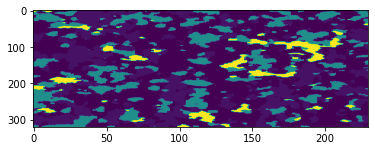

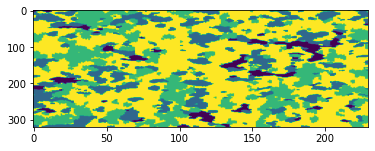

In [19]:
plt.imshow(tprogs[:,0,:],aspect=1/4)
plt.show()
plt.imshow(tprogs_arr[:,0,:],aspect=1/4)

In [113]:
# use dem elevation to get tprogs layer at ground surface
tprogs_top_ind = ((dem_data+80)*2).astype(int)
# take any indices above the top of the tprogs top to be the max
tprogs_top_ind[tprogs_top_ind>=320] = 319
# create empty array to keep tprogs data from ground surface
tprogs_ground = np.zeros(dem_data.shape)
for i in np.arange(0,dem_data.shape[0]):
    for j in np.arange(0,dem_data.shape[1]):
        tprogs_ground[i,j] = tprogs[tprogs_top_ind[i,j],i,j]

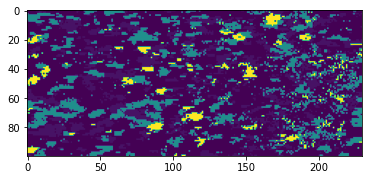

In [115]:
plt.imshow(tprogs_ground)

In [46]:
# remove columns with extra grid information as new grid information will be joined after buffering
sfr = grid_sfr.loc[:,['Point_orde','length_m','reach','geometry']]

In [127]:
def sfr_tprogs(sfr,dem_data, dist):
    # buffer the sfr grid cells by a distance to expand out from the channel
    sfr_buf = sfr.copy()
    sfr_buf.geometry = sfr_buf.buffer(dist)
    # join buffered sfr line with model grid to find new bunch of cells that are in the channel
    sfr_buf_grid = gpd.sjoin(grid_p, sfr_buf, op='within')
    # create array to be filled with cells that sfr array is in contact with
    sfr_arr = np.zeros(dem_data.shape)
    sfr_arr[:] = np.nan
    # fill sfr_arr with tprogs cell
    sfr_arr[sfr_buf_grid.row,sfr_buf_grid.column] = tprogs_ground[sfr_buf_grid.row,sfr_buf_grid.column]
    return(sfr_buf_grid, sfr_arr)


In [148]:
sfr_buf = sfr.copy()
dist=0
sfr_buf.geometry = sfr_buf.buffer(dist)
# join buffered sfr line with model grid to find new bunch of cells that are in the channel
sfr_buf_grid = gpd.sjoin(grid_p, sfr_buf, op='within')
# create array to be filled with cells that sfr array is in contact with
sfr_arr = np.zeros(dem_data.shape)
sfr_arr[:] = np.nan
# fill sfr_arr with tprogs cell
sfr_arr[sfr_buf_grid.row,sfr_buf_grid.column] = tprogs_ground[sfr_buf_grid.row,sfr_buf_grid.column]
sfr_buf_grid

,node,row,column,geometry,index_right,Point_orde,length_m,reach
8815,8816,38,75,"POLYGON ((644658.079 4247143.538, 644778.720 4...",176,4310.5,120,177
9039,9040,39,69,"POLYGON ((644093.746 4246065.796, 644214.387 4...",182,4431.0,190,183
9040,9041,39,70,"POLYGON ((644214.387 4246225.313, 644335.029 4...",181,4410.5,220,182
9041,9042,39,71,"POLYGON ((644335.029 4246384.829, 644455.671 4...",180,4389.5,200,181
9042,9043,39,72,"POLYGON ((644455.671 4246544.346, 644576.312 4...",179,4369.5,200,180
...,...,...,...,...,...,...,...,...
21374,21375,92,214,"POLYGON ((670041.168 4262801.725, 670161.809 4...",4,361.0,110,5
21375,21376,92,215,"POLYGON ((670161.809 4262961.242, 670282.451 4...",3,345.0,210,4
21376,21377,92,216,"POLYGON ((670282.451 4263120.759, 670403.092 4...",2,324.5,200,3
21607,21608,93,217,"POLYGON ((670562.609 4263159.634, 670683.251 4...",1,298.5,240,2


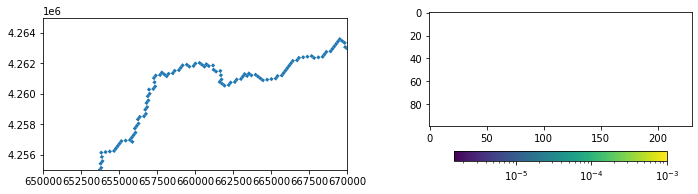

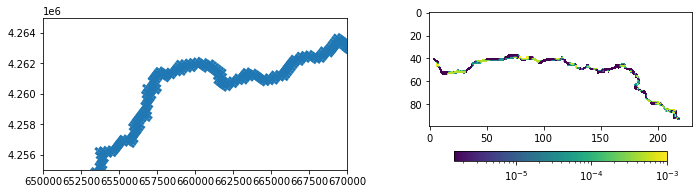

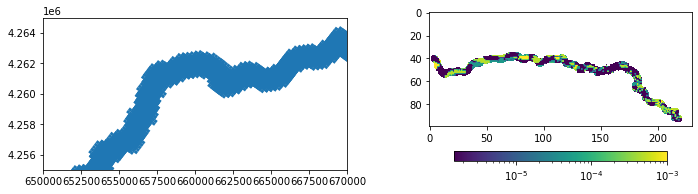

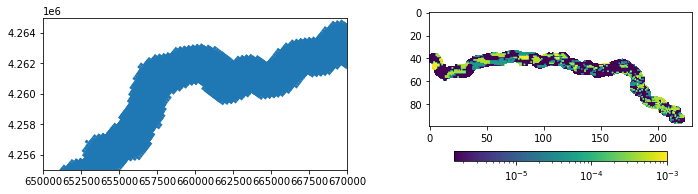

In [154]:
for dist in np.arange(0,1600,400):
    sfr_buf_grid, sfr_arr = sfr_tprogs(sfr,dem_data,dist=dist)
    fig,ax=plt.subplots(1,2,figsize=(12,3))
    sfr_buf_grid.plot(ax=ax[0])
    # focus in on middle section to look at buffer effect
    ax[0].set_ylim(4.255e6,4.265e6)
    ax[0].set_xlim(6.5e5, 6.7e5)
    # plot tprogs data
    im=ax[1].imshow(sfr_arr,norm=mpl.colors.LogNorm())
    plt.colorbar(im,ax=ax[1],orientation='horizontal',shrink = 0.7)
    plt.show()

In [123]:
# create array to be filled with cells that sfr array is in contact with
sfr_arr = np.zeros(dem_data.shape)
sfr_arr[:] = np.nan
# fill sfr_arr with tprogs cell
sfr_arr[sfr_buf_grid.row,sfr_buf_grid.column] = tprogs_ground[sfr_buf_grid.row,sfr_buf_grid.column]
plt.imshow(sfr_arr, norm=mpl.colors.LogNorm())

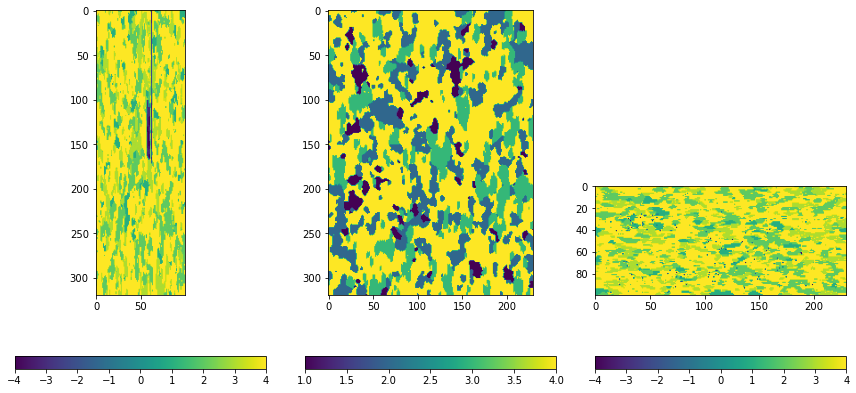

In [65]:
# # col, row, layer 230, 100, 320
# # tprogs_arr = np.reshape(tprogs_line, (230, 100,320))
# tprogs_arr = np.reshape(tprogs_line, (320, 100, 230 ))

# fig, ax = plt.subplots(1,3, figsize=(12,6))
# #first layer
# im = ax[0].imshow(tprogs_arr[:,:,0])
# fig.colorbar(im, ax=ax[0], orientation = 'horizontal')
# # first row
# im = ax[1].imshow(tprogs_arr[:,0,:])
# fig.colorbar(im, ax=ax[1], orientation = 'horizontal')
# # first column
# im = ax[2].imshow(tprogs_arr[0,:,:])
# fig.colorbar(im, ax=ax[2], orientation = 'horizontal')
# fig.tight_layout()